In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import util
from ipywidgets import interact_manual

%matplotlib inline


In [2]:
images_rgb = util.images_in_directory('output_images/bird_view')

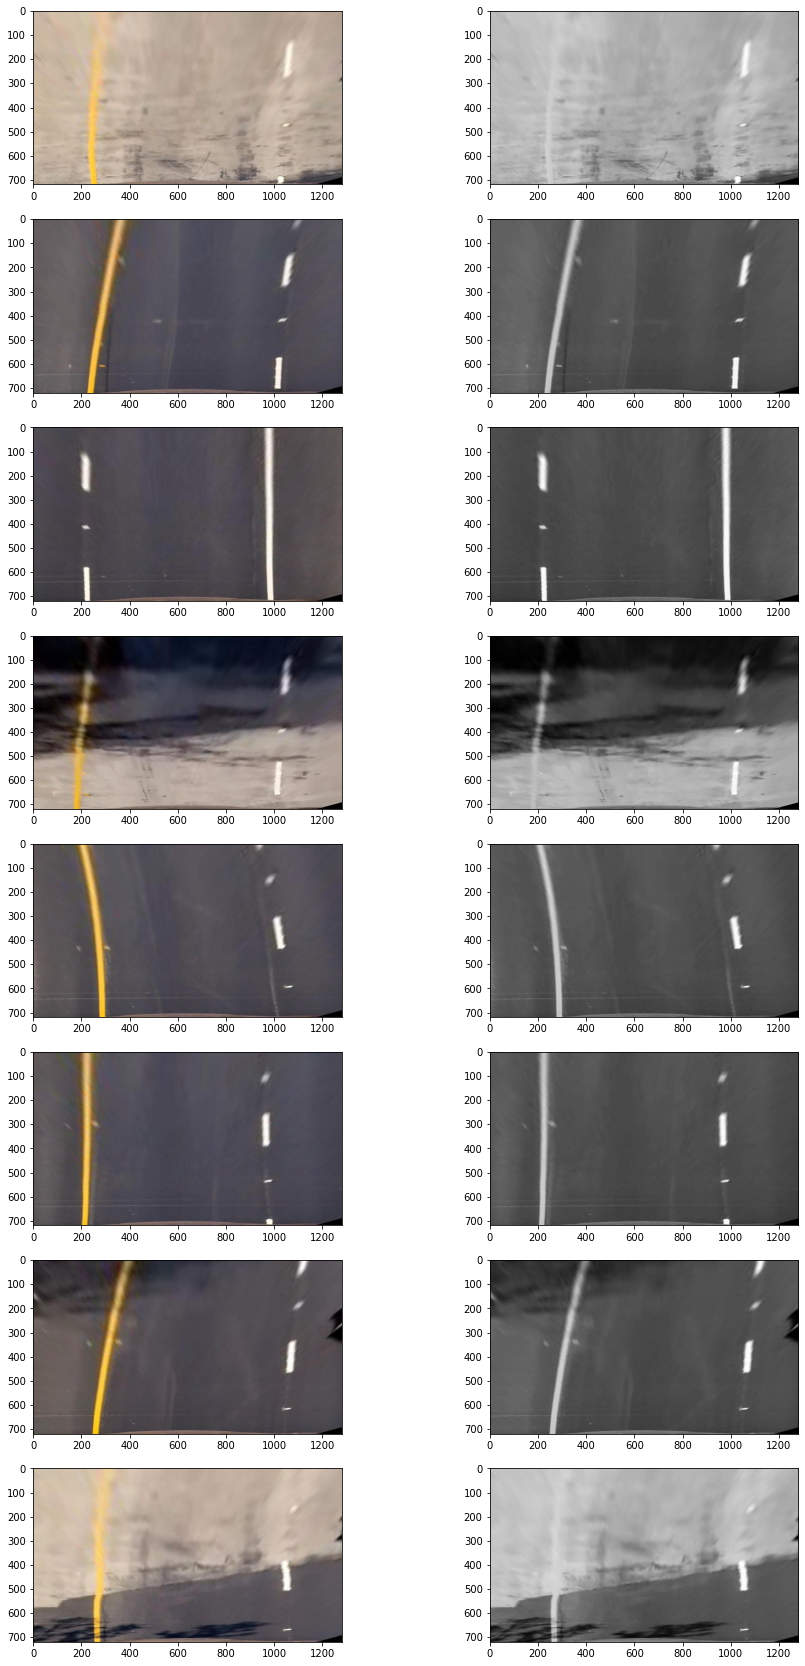

In [19]:
util.show_side_by_side(images_rgb, lambda i: cv2.cvtColor(i, cv2.COLOR_RGB2GRAY), cmap='gray')

# Red channel
Of red/green/blue, most contrast in red


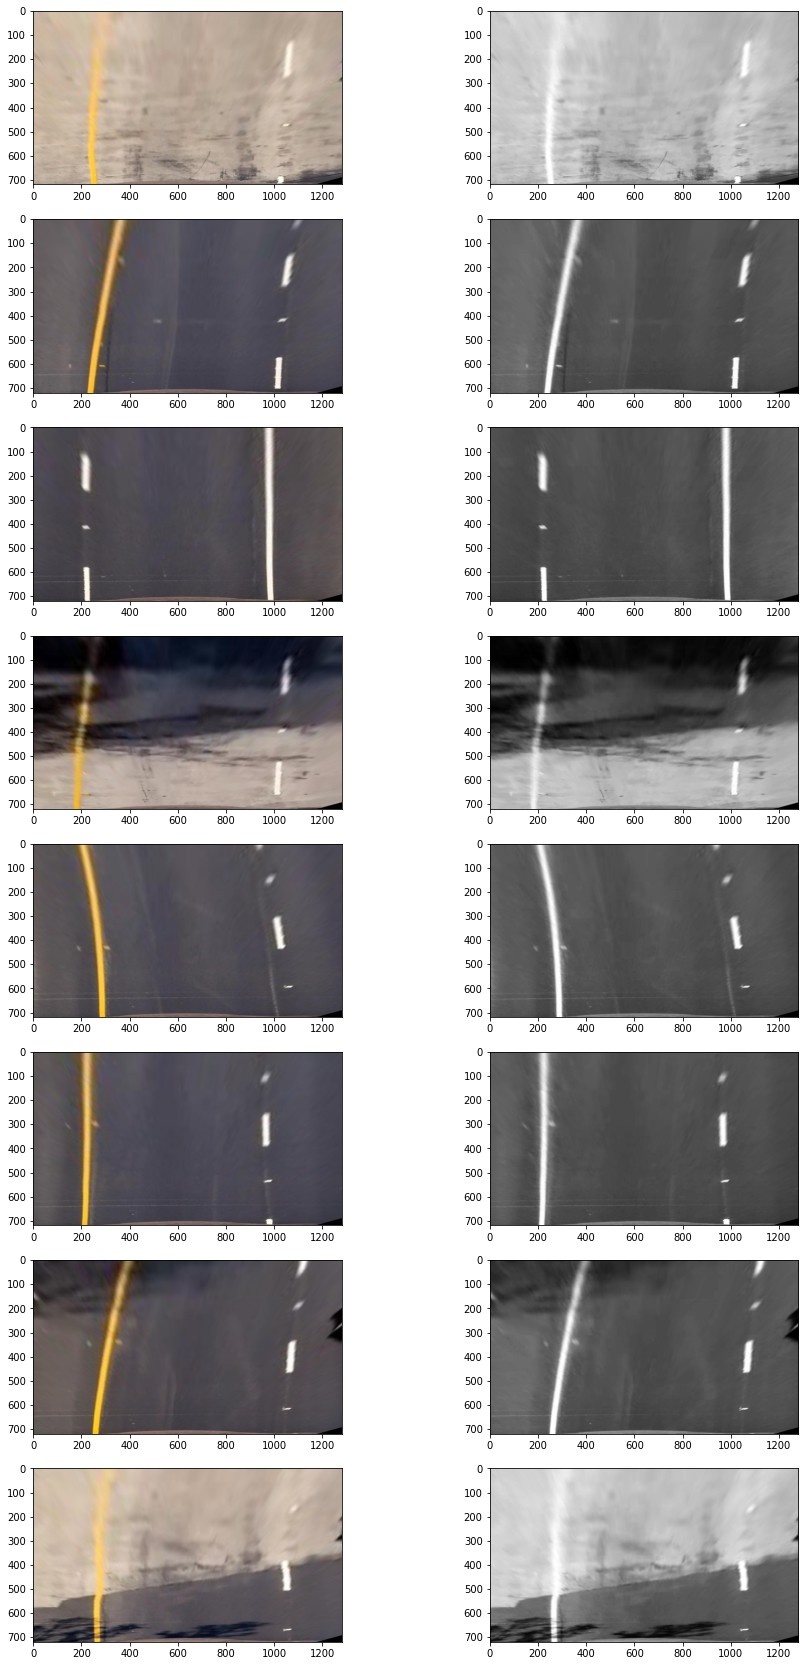

In [3]:
util.show_side_by_side(images_rgb, lambda i: i[:,:,0], cmap='gray')

# Green channel

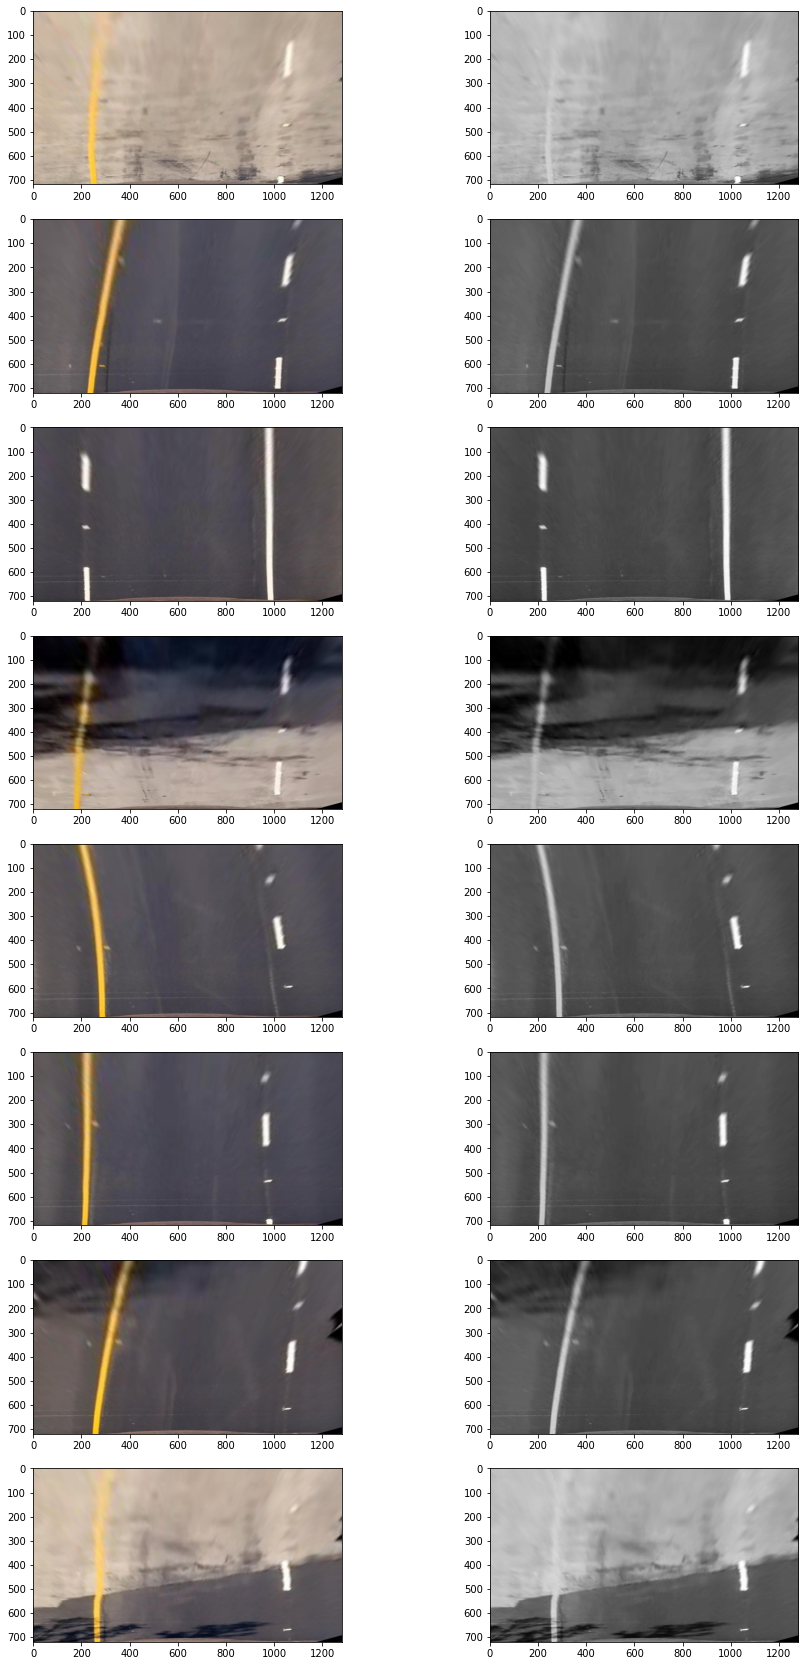

In [4]:
util.show_side_by_side(images_rgb, lambda i: i[:,:,1], cmap='gray')

# Blue channel
Lacks contracts between yellow line and rest of road

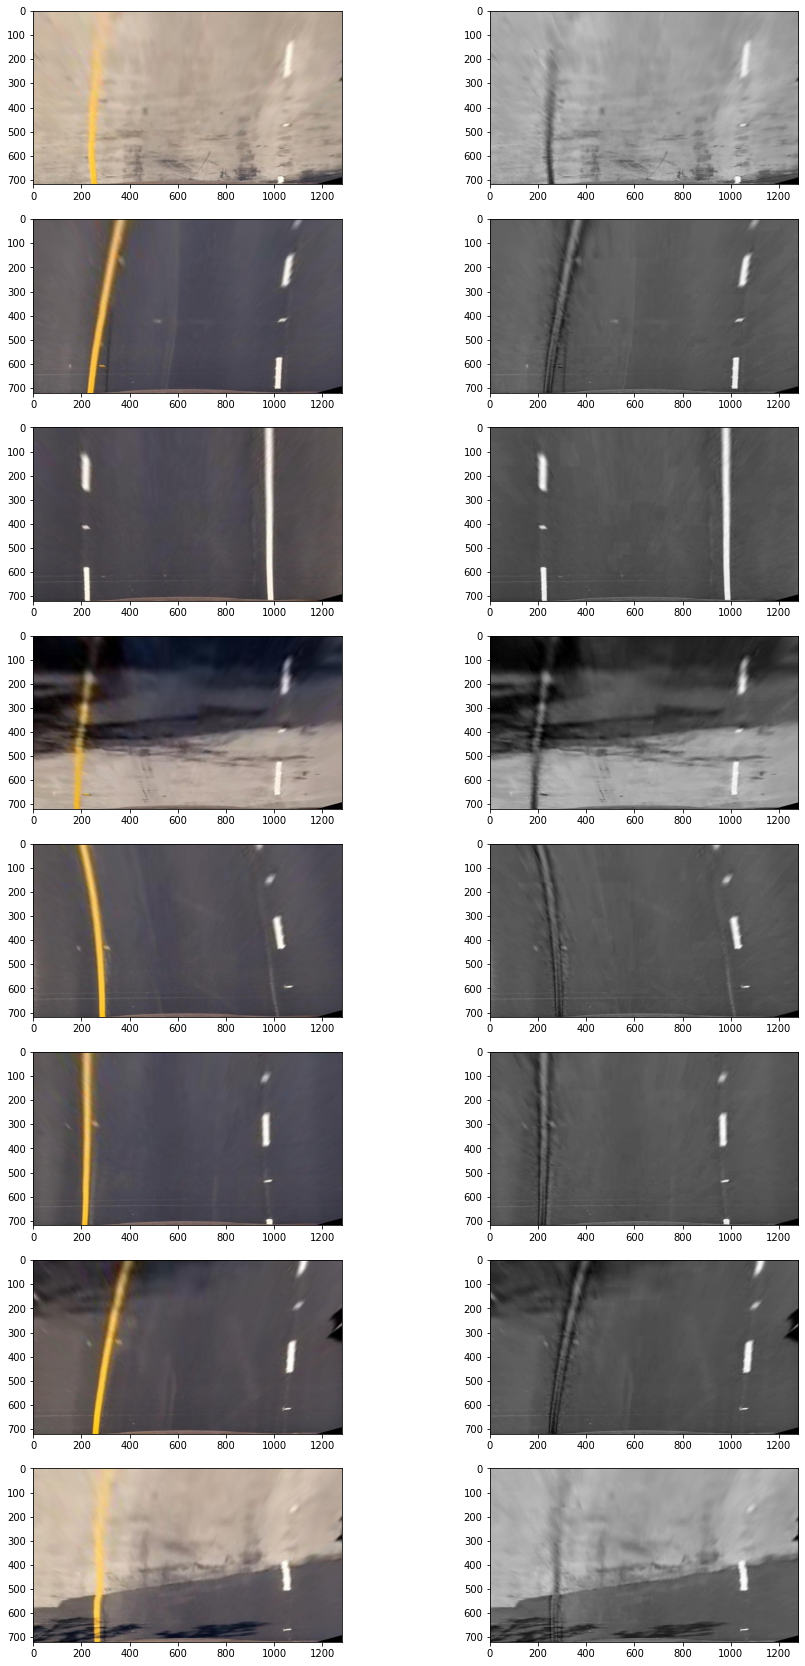

In [5]:
util.show_side_by_side(images_rgb, lambda i: i[:,:,2], cmap='gray')

# Hue

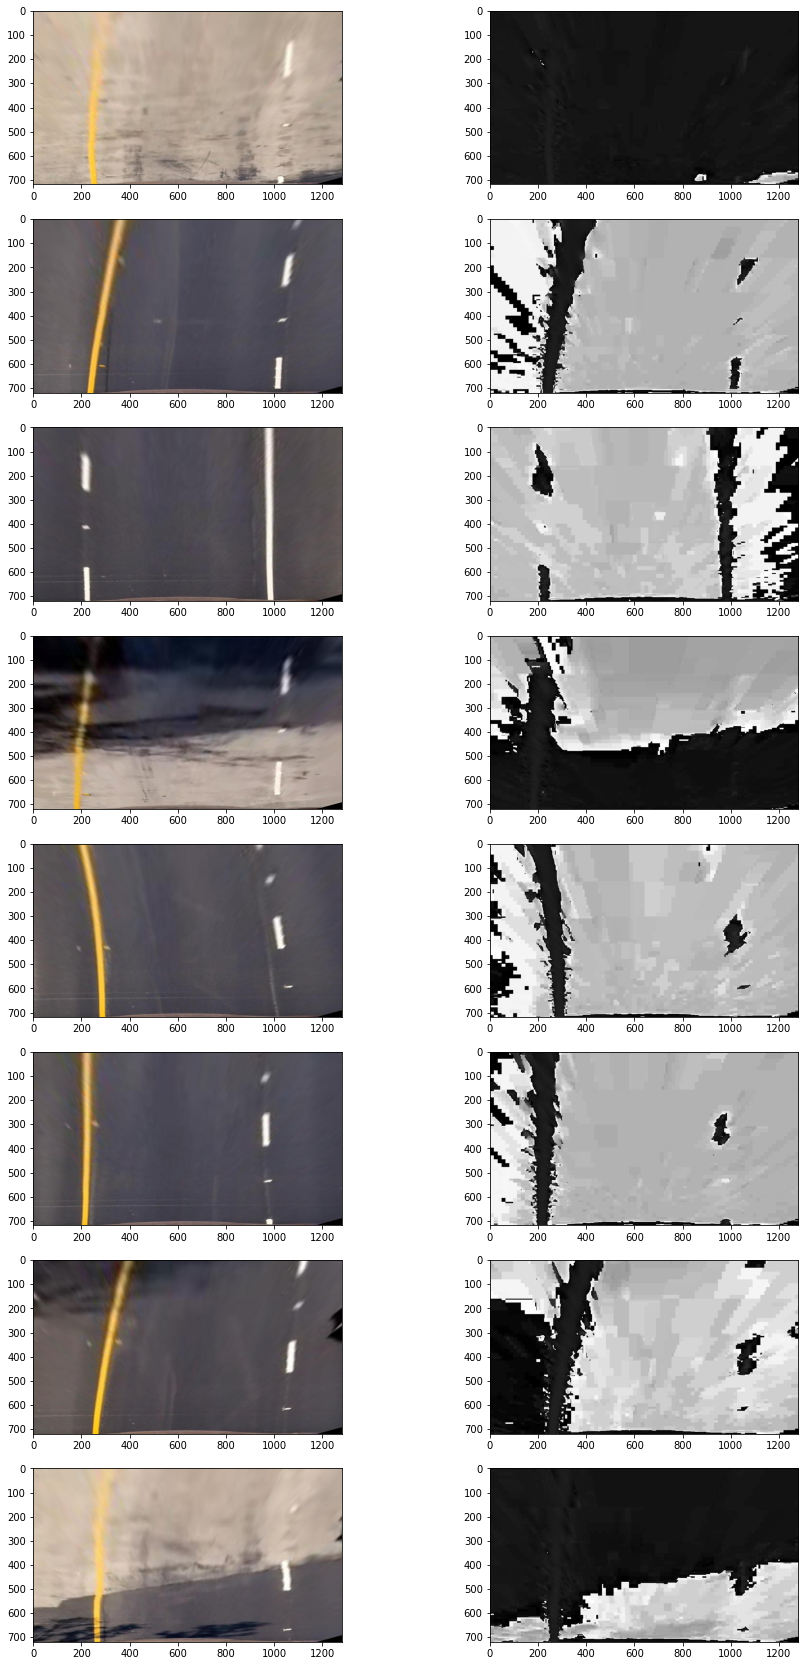

In [6]:
util.show_side_by_side(images_rgb, lambda i: cv2.cvtColor(i, cv2.COLOR_RGB2HLS)[:,:,0], cmap='gray')

# Lightness

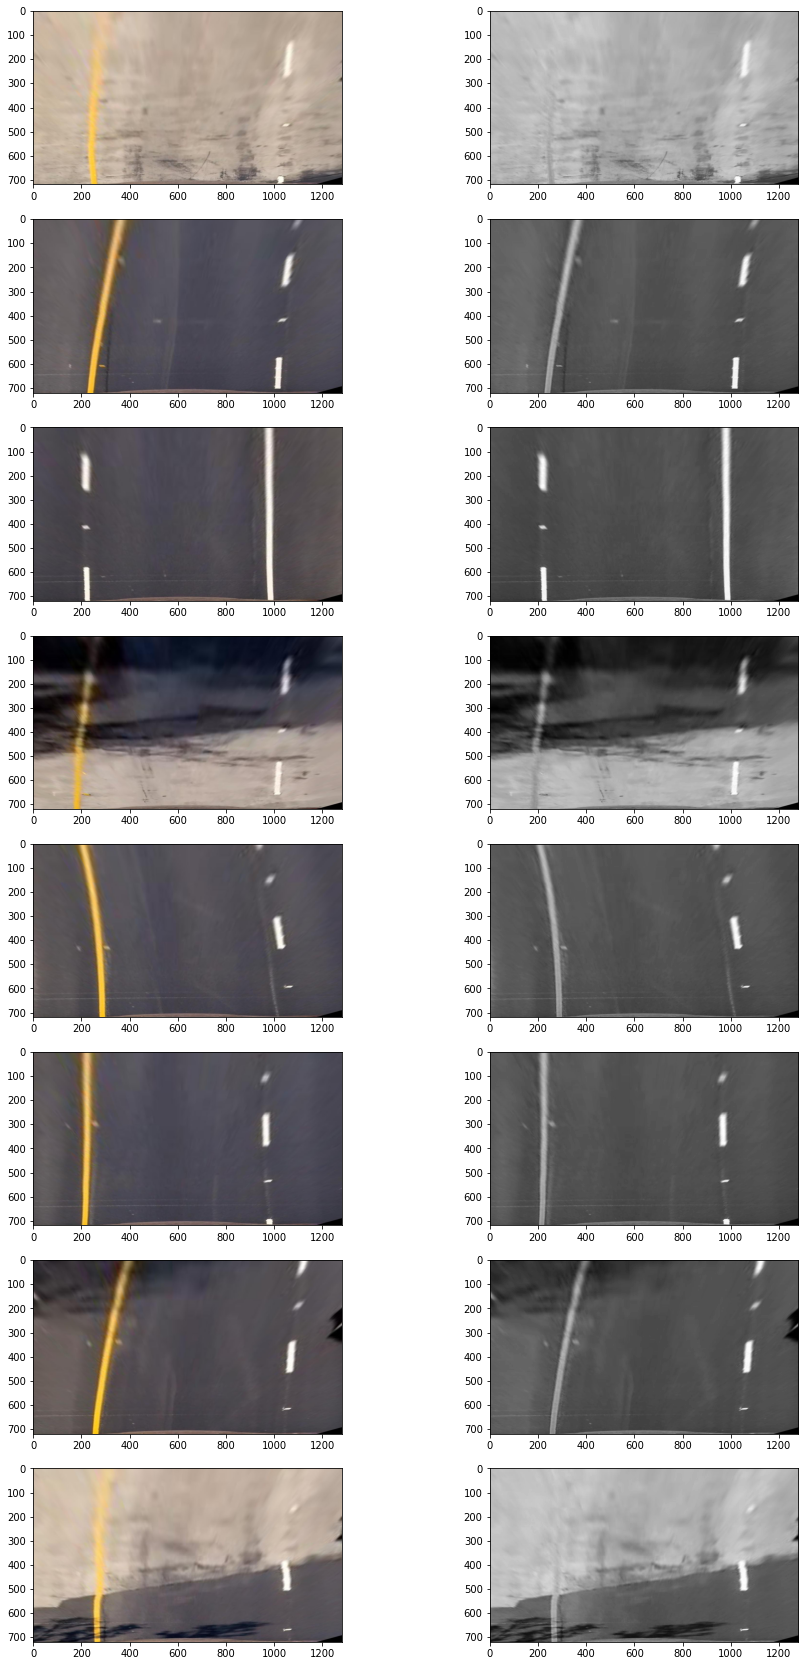

In [7]:
util.show_side_by_side(images_rgb, lambda i: cv2.cvtColor(i, cv2.COLOR_RGB2HLS)[:,:,1], cmap='gray')

# Saturation

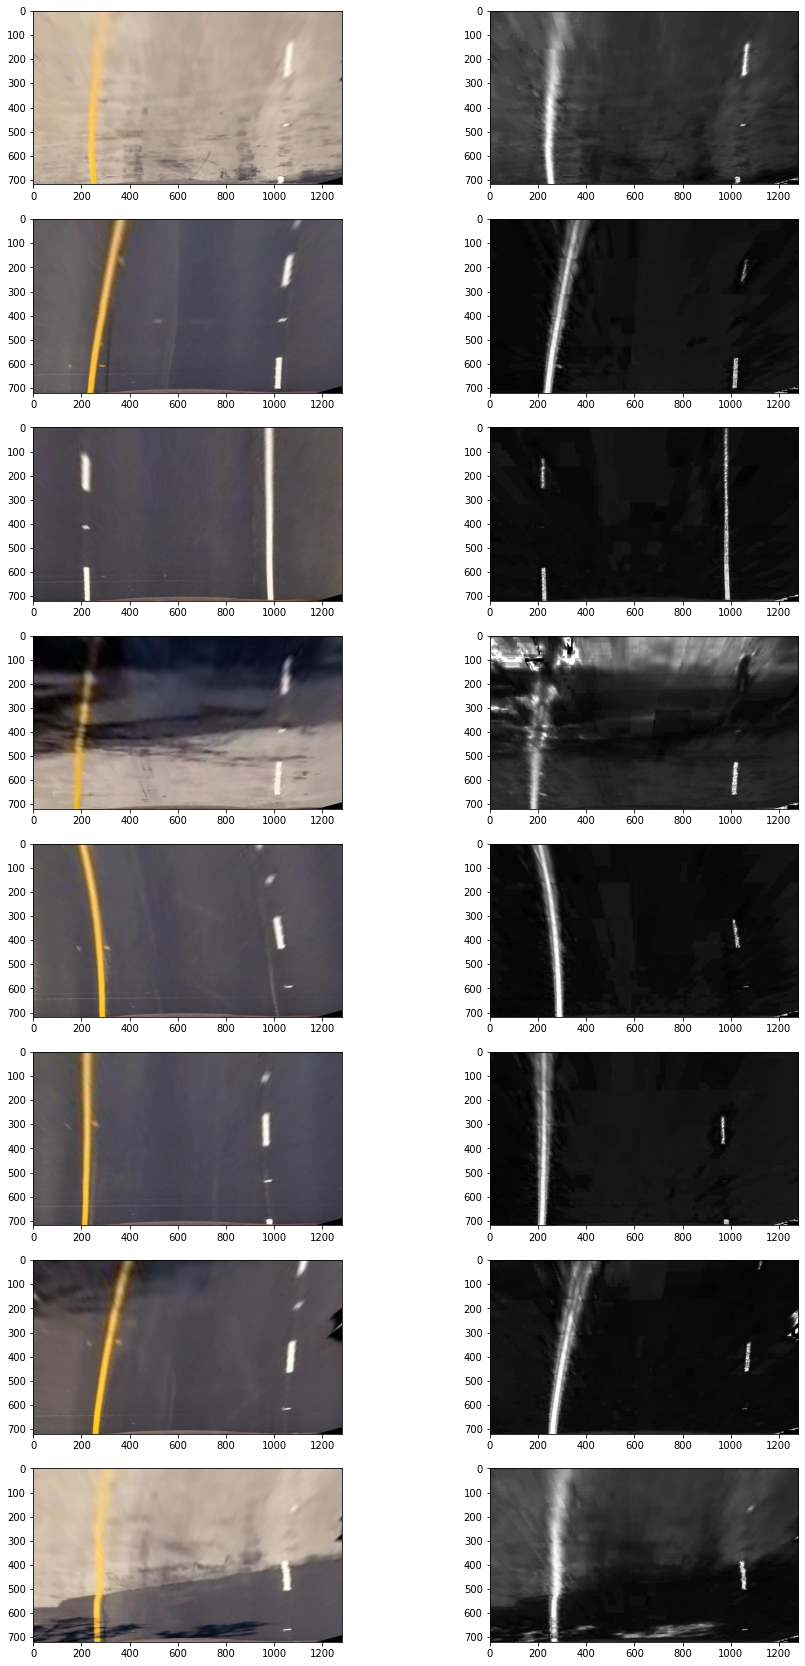

In [8]:
util.show_side_by_side(images_rgb, lambda i: cv2.cvtColor(i, cv2.COLOR_RGB2HLS)[:,:,2], cmap='gray')

In [9]:
@interact_manual(low=(0,255,5), high=(0,255,5))
def experiment_with_saturation(low,high):
    def binary_saturation(image):
        hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_img = hls_img[:, :, 2]
        binary_output = np.zeros_like(s_img)
        binary_output[(s_img > low) & (s_img <= high)] = 1
        return binary_output
    util.show_side_by_side(images_rgb, binary_saturation, cmap='gray')

interactive(children=(IntSlider(value=125, description='low', max=255, step=5), IntSlider(value=125, descripti…

In [10]:
@interact_manual(low=(0,255,5), high=(0,255,5))
def experiment_with_red(low,high):
    def binary_red(image):
        red_img = image[:, :, 0]
        binary_output = np.zeros_like(red_img)
        binary_output[(red_img > low) & (red_img <= high)] = 1
        return binary_output
    util.show_side_by_side(images_rgb, binary_red, cmap='gray')

interactive(children=(IntSlider(value=125, description='low', max=255, step=5), IntSlider(value=125, descripti…

In [11]:
@interact_manual(low_red=(0,255,5), low_sat=(0,255,5))
def experiment_with_red_and_saturation(low_red,low_sat):
    def binary_red(image):
        red_img = image[:, :, 0]
        binary_output = np.zeros_like(red_img)
        binary_output[(red_img > low_red) & (red_img <= 255)] = 1
        return binary_output
    def binary_saturation(image):
        hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_img = hls_img[:, :, 2]
        binary_output = np.zeros_like(s_img)
        binary_output[(s_img > low_sat) & (s_img <= 255)] = 1
        return binary_output
    def and_binaries(bin_function1, bin_function2):
        def combined(image):
            i_1 = bin_function1(image)
            i_2 = bin_function2(image)
            i_and = np.zeros_like(i_1)
            i_and[(i_1 == 1) & (i_2 == 1)] = 1
            return i_and
        return combined
    util.show_side_by_side(images_rgb, and_binaries(binary_red, binary_saturation), cmap='gray')

interactive(children=(IntSlider(value=125, description='low_red', max=255, step=5), IntSlider(value=125, descr…

In [12]:
# let's go for red: 40, sat: 120 which we need to _or_ with something else to fill in the shadowy parts
def binary_red(image, low=40, high=255):
    red_img = image[:, :, 0]
    binary_output = np.zeros_like(red_img)
    binary_output[(red_img > low) & (red_img <= high)] = 1
    return binary_output
def binary_saturation(image,low=120,high=255):
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_img = hls_img[:, :, 2]
    binary_output = np.zeros_like(s_img)
    binary_output[(s_img > low) & (s_img <= high)] = 1
    return binary_output
def and_binaries(bin_function1, bin_function2):
    def combined(image):
        i_1 = bin_function1(image)
        i_2 = bin_function2(image)
        i_and = np.zeros_like(i_1)
        i_and[(i_1 == 1) & (i_2 == 1)] = 1
        return i_and
    return combined
def or_binaries(bin_function1, bin_function2):
    def combined(image):
        i_1 = bin_function1(image)
        i_2 = bin_function2(image)
        i_and = np.zeros_like(i_1)
        i_and[(i_1 == 1) | (i_2 == 1)] = 1
        return i_and
    return combined

In [20]:

def absolute_sobel(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    orientation = [1, 0] if orient == 'x' else [0, 1]
    derivative = cv2.Sobel(grayscale, cv2.CV_64F, *orientation, ksize=sobel_kernel)
    absolute_derivative = np.absolute(derivative)
    scaled = np.uint8(255 * absolute_derivative/np.max(absolute_derivative))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    return binary_output


def absolute_sobel_red(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    grayscale = img[:,:,0]
    orientation = [1, 0] if orient == 'x' else [0, 1]
    derivative = cv2.Sobel(grayscale, cv2.CV_64F, *orientation, ksize=sobel_kernel)
    absolute_derivative = np.absolute(derivative)
    scaled = np.uint8(255 * absolute_derivative/np.max(absolute_derivative))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    return binary_output


def magnitude(img, sobel_kernel=3,  thresh=(0,255)):
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    derivative_x = cv2.Sobel(grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    derivative_y = cv2.Sobel(grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absolute_derivative = np.sqrt(derivative_x**2 + derivative_y**2)
    scaled = np.uint8(255 * absolute_derivative/np.max(absolute_derivative))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled <= thresh[1])] = 1
    return binary_output

def directional(img, sobel_kernel=3,  thresh=(0, np.pi/2)):
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    derivative_x = cv2.Sobel(grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    derivative_y = cv2.Sobel(grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    direction = np.arctan2(np.absolute(derivative_y), np.absolute(derivative_x))
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output


In [24]:
@interact_manual(low=(0,255,5), high=(0,255,5), orient=[('x','x'), ('y','y')], sobel=(3,15,2))
def experiment_with_absolute(low,high,orient,sobel):
    util.show_side_by_side(images_rgb, lambda i: absolute_sobel(i, orient, sobel, thresh=(low, high)), cmap='gray')

interactive(children=(IntSlider(value=125, description='low', max=255, step=5), IntSlider(value=125, descripti…

In [23]:
@interact_manual(low=(0,255,5), high=(0,255,5), orient=[('x','x'), ('y','y')], sobel=(3,15,2))
def experiment_with_absolute(low,high,orient,sobel):
    util.show_side_by_side(images_rgb, lambda i: absolute_sobel_red(i, orient, sobel, thresh=(low, high)), cmap='gray')

interactive(children=(IntSlider(value=125, description='low', max=255, step=5), IntSlider(value=125, descripti…

In [16]:
@interact_manual(low=(0,255,5), high=(0,255,5), sobel=(3,15,2))
def experiment_with_magnitude(low,high,sobel):
    util.show_side_by_side(images_rgb, lambda i: magnitude(i, sobel, thresh=(low, high)), cmap='gray')

interactive(children=(IntSlider(value=125, description='low', max=255, step=5), IntSlider(value=125, descripti…

In [17]:
#@interact_manual(low=(0., np.pi/2, 0.01), high=(0., np.pi/2, 0.01), low_mag=(0,255,2), sobel=(3,15,2), min_sat=(0,255,1))
@interact_manual(low=(0,255,2),high=(0,255,1), sobel=(3,15,2), low_mag=(0,255,1))
def experiment_with_directional(low,high,low_mag,sobel):
    #    sobel_combo = and_binaries(lambda i: directional(i,sobel, thresh=(low, high)), )
    sat_combo = and_binaries(lambda i: absolute_sobel(i, 'x', sobel, thresh=(low, high)), lambda i: magnitude(i,sobel, thresh=(low_mag, 255)))
    util.show_side_by_side(images_rgb, sat_combo, cmap='gray')

interactive(children=(IntSlider(value=126, description='low', max=255, step=2), IntSlider(value=127, descripti…

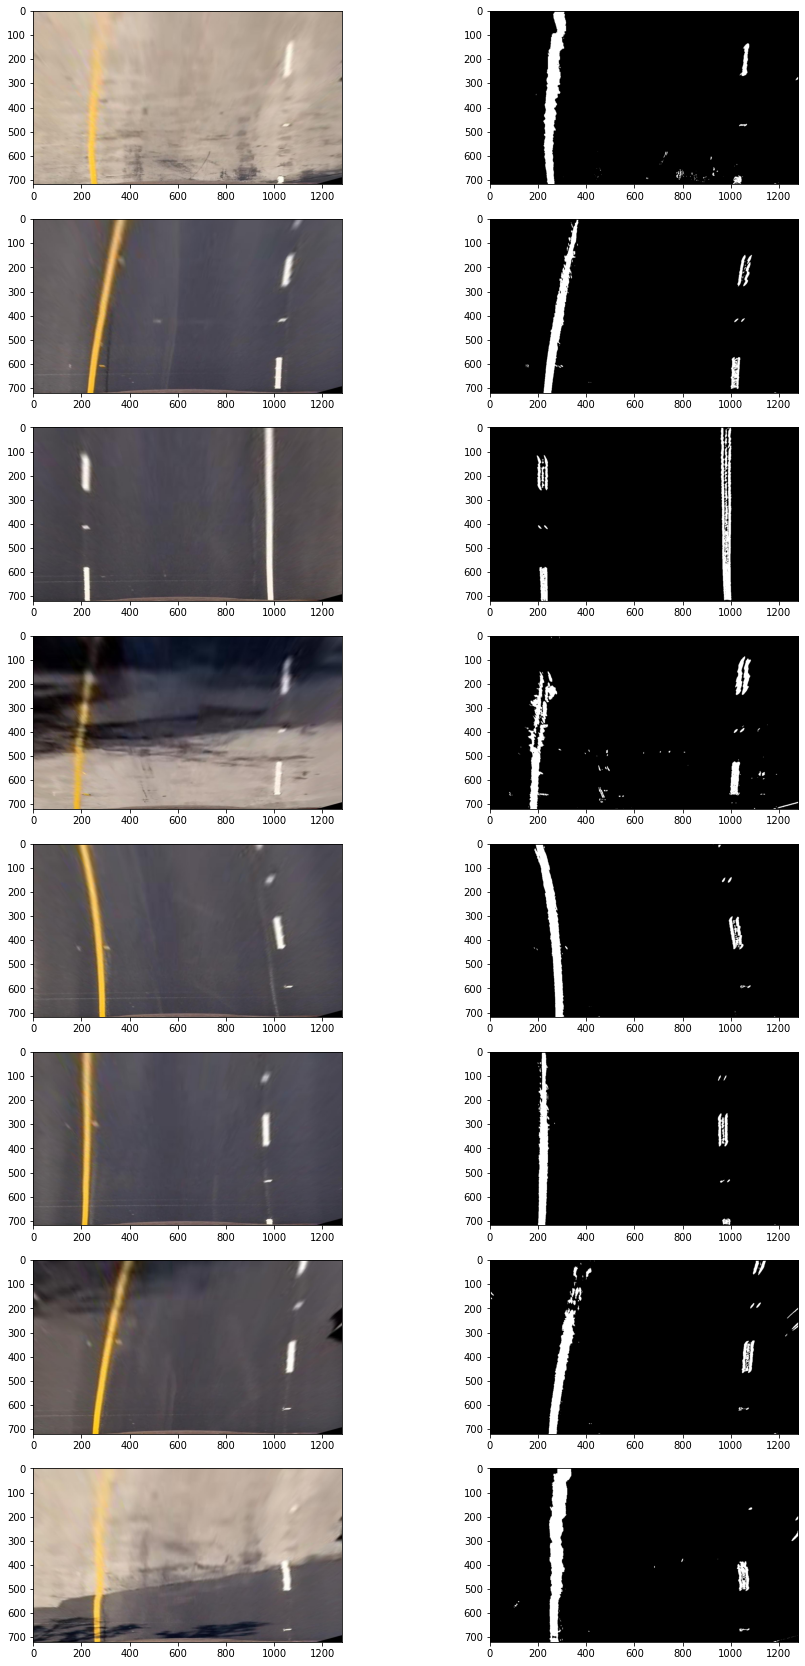

In [25]:
# directional: 0 - 0.5 at 3 gives fun results in shadowy stuff. But noisy, maybe combine with magnitude?

sobel_combo = and_binaries(lambda i: directional(i, 9, thresh=(0, 0.6)), lambda i: magnitude(i, 9, thresh=(15, 255)))
#unclear_lines = and_binaries(sobel_combo, lambda i: binary_saturation(i, 30))
unclear_lines = lambda i: absolute_sobel_red(i, 'x', 9, thresh=(50, 255))
clear_lines = and_binaries(lambda i: binary_red(i, 40), lambda i: binary_saturation(i, 130))
util.show_side_by_side(images_rgb, or_binaries(unclear_lines, clear_lines), cmap='gray')